# Exploratory marker analyses of PBMCs at time point 1
----


---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
import tifffile
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from tqdm import tqdm
import sys
import cv2 as cv
import umap
import umap.plot
from statannot import add_stat_annotation

sys.path.append("../..")
from src.utils.io import get_file_list

seed = 1234
np.random.seed(seed)
random.seed(seed)

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
def read_in_dataset(
    data_dir,
    feature_file_path,
    qc_result_file_path,
    label_file_path,
    crop_images_path,
    n_crop_images=9,
):
    all_features = []
    nuclei_dict = {}
    subdirs = [f.path for f in os.scandir(data_dir) if f.is_dir()]
    for subdir in tqdm(subdirs, desc="Load data"):
        feature_path = subdir + feature_file_path
        features = pd.read_csv(feature_path, index_col=0)
        features["sample"] = os.path.split(subdir)[1].split("_")[0].lower()
        qc_result_path = subdir + qc_result_file_path
        qc_results = pd.read_csv(qc_result_path, index_col=0)
        features.loc[qc_results.index, "qc_pass"] = qc_results.loc[
            qc_results.index, "qc_pass"
        ]
        label_features = pd.read_csv(subdir + label_file_path, index_col=0)
        features = features.join(label_features)
        all_features.append(features)
        crops_path = subdir + crop_images_path
        nuclei_dict[features["sample"][0]] = get_sample_crops(
            data_dir=crops_path, n_images=n_crop_images
        )
    all_features_df = all_features[0].copy()
    for i in range(1, len(all_features)):
        all_features_df = all_features_df.append(all_features[i])
    return nuclei_dict, all_features_df

<IPython.core.display.Javascript object>

In [3]:
def get_sample_crops(data_dir, n_images=9):
    crop_locs = get_file_list(data_dir)
    selected_crop_locs = np.random.choice(crop_locs, size=n_images, replace=False)
    images = []
    for loc in selected_crop_locs:
        images.append(tifffile.imread(loc))
    return images

<IPython.core.display.Javascript object>

In [4]:
def plot_multi_channel_image_grid(name, images, channel=0, cmap="viridis"):
    nrow = int(np.sqrt(len(images)))
    ncol = int(len(images) / nrow)
    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=[6, 6])
    ax = ax.flatten()
    for i in range(len(ax)):
        ax[i].imshow(
            cv.resize(images[i][channel, :, :], dsize=(64, 64)),
            cmap=cmap,
            vmin=0,
            vmax=2 ** 16,
        )
        ax[i].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle("Sample: {}, channel: {}".format(name.upper(), channel))
    plt.show()
    plt.close()

<IPython.core.display.Javascript object>

In [5]:
def plot_feature_importance(importance, names, model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {"feature_names": feature_names, "feature_importance": feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)
    fi_df = fi_df.head(20)
    # Define size of bar plot
    plt.figure(figsize=(8, 6))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df["feature_importance"], y=fi_df["feature_names"])
    # Add chart labels
    plt.title(model_type + "FEATURE IMPORTANCE")
    plt.xlabel("FEATURE IMPORTANCE")
    plt.ylabel("FEATURE NAMES")
    plt.show()

<IPython.core.display.Javascript object>

In [6]:
def plot_roc_for_stratified_cv(X, y, n_splits, classifier, title, pos_label=None):
    cv = StratifiedKFold(n_splits=n_splits)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(8, 8))
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(
            classifier,
            X[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
            pos_label=pos_label,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=title)
    ax.legend(loc="lower right")
    return fig, ax, classifier

<IPython.core.display.Javascript object>

---

## 1. Read in data

First we will read in the data for the different healthy samples. To this end, we will automatically iterate over all subdirectories in a given root data directory. Each subdirectory is expected to include the data corresponding to one of the healthy individuals. If preprocessed using the previously described preprocessing pipeline each of those sub-directories includes the nuclear features corresponding to the respective sub-data set.

In [7]:
hv_root_data_dir = "../../data/pbmc_hv/marker/"
hv_feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
hv_crop_images_path = "/preprocessed/full_pipeline/segmentation/nuclear_crops_2d"
hv_qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"
hv_label_file_path = "/preprocessed/full_pipeline/marker_labels/marker_labels.csv"

<IPython.core.display.Javascript object>

In [8]:
hv_sample_images, hv_features = read_in_dataset(
    data_dir=hv_root_data_dir,
    feature_file_path=hv_feature_file_path,
    qc_result_file_path=hv_qc_result_file_path,
    crop_images_path=hv_crop_images_path,
    label_file_path=hv_label_file_path,
    n_crop_images=9,
)
hv_features.loc[:, "condition"] = "healthy"

Load data: 100%|██████████| 4/4 [00:00<00:00, 22.79it/s]


<IPython.core.display.Javascript object>

In [9]:
pt_root_data_dir = "../../data/pbmc_pt/marker/timepoint_1/"
pt_feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
pt_crop_images_path = "/preprocessed/full_pipeline/segmentation/nuclear_crops_2d"
pt_qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"
pt_label_file_path = "/preprocessed/full_pipeline/marker_labels/marker_labels.csv"

<IPython.core.display.Javascript object>

In [11]:
pt_sample_images, pt_features = read_in_dataset(
    data_dir=pt_root_data_dir,
    feature_file_path=pt_feature_file_path,
    qc_result_file_path=pt_qc_result_file_path,
    crop_images_path=pt_crop_images_path,
    label_file_path=pt_label_file_path,
    n_crop_images=9,
)
pt_features.loc[:, "condition"] = "cancer"

Load data: 100%|██████████| 4/4 [00:00<00:00, 23.63it/s]


<IPython.core.display.Javascript object>

In [12]:
nuclear_features = hv_features.append(pt_features)
nuclear_features

label  min_calliper  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0         1          56.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1         2          57.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2         3          70.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3         4          60.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_4         5          57.0   
...                                                   ...           ...   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...      7          58.0   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...      8          58.0   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...      9          61.0   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...     10          62.0   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...     11          67.0   

                                                    max_calliper  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0             69.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1             69.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2             80.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3             77.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_4             73.0   
...                                                          ...   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...          78.0   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...          88.0   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...          75.0   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...          80.0   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...          80.0   

                                                    smallest_largest_calliper  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0                      0.811594   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1                      0.826087   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2                      0.875000   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3                      0.779221   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_4                      0.780822   
...                                                                       ...   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...                   0.743590   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...                   0.659091   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...                   0.813333   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...                   0.775000   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...                   0.837500   

                                                    min_radius  max_radius  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0      25.414238   34.808384   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1      21.888176   34.632301   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2      27.110249   40.680998   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3      23.044278   40.132092   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_4      16.300251   41.194658   
...                                                        ...         ...   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...   25.052234   39.030582   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...   21.943329   45.789304   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...   18.987316   40.190915   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...   29.218866   40.599333   
P16_1st point_PBMCs_Dapi_CD8_CD4_26_08_21_2X_16...   28.589046   39.799276   

                                                    med_radius  avg_radius  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0      30.449537   30.342112   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1      31.093053   30.915548   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2      36.292256   36.137461   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3      32.721444   32.905978   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X

<IPython.core.display.Javascript object>

---

## 2. Overview of the data

After reading in the data, we will provide a first overview of the data, by plotting 9 randomly sampled, max-z projected nuclei for each biological sample in all three channels.

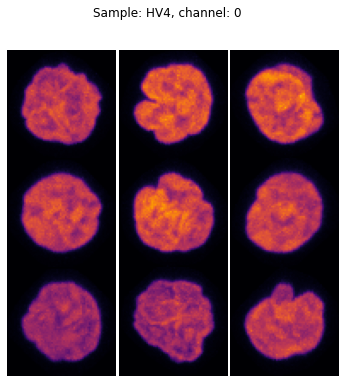

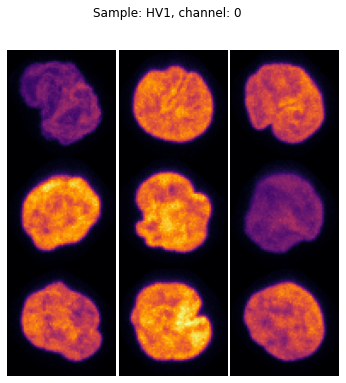

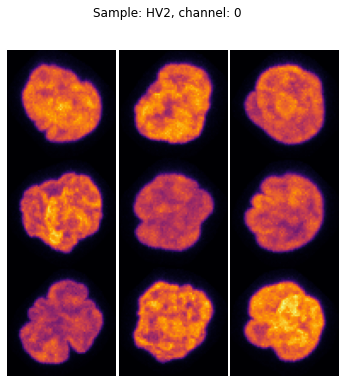

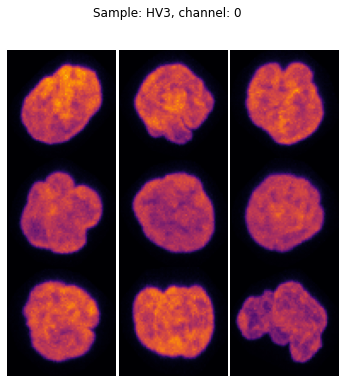

<IPython.core.display.Javascript object>

In [13]:
for k, v in hv_sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=0, cmap="inferno")

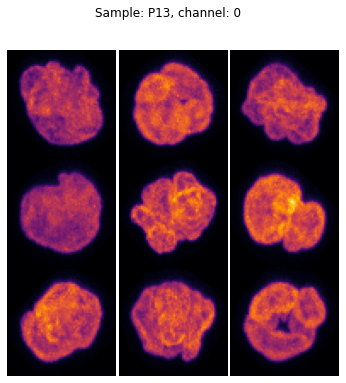

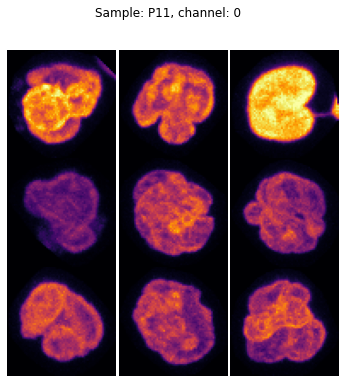

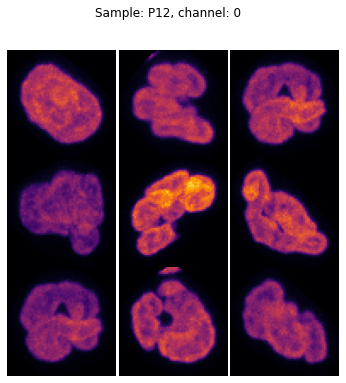

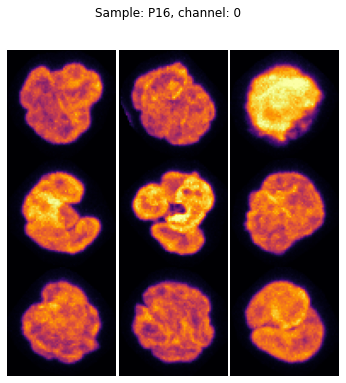

<IPython.core.display.Javascript object>

In [14]:
for k, v in pt_sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=0, cmap="inferno")

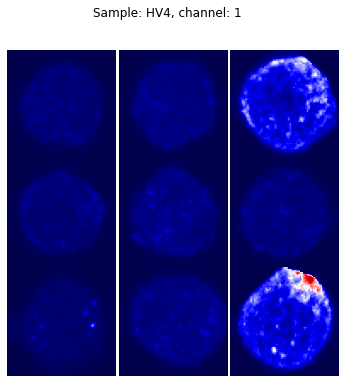

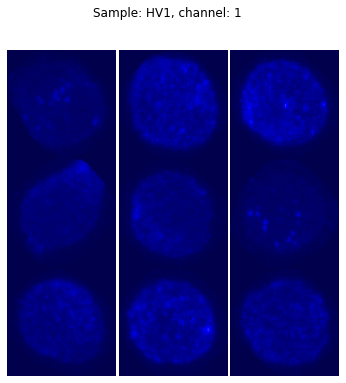

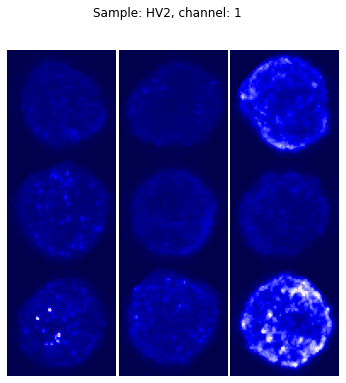

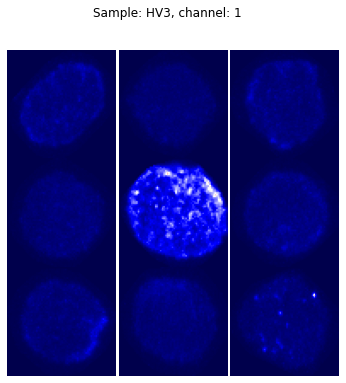

<IPython.core.display.Javascript object>

In [15]:
for k, v in hv_sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=1, cmap="seismic")

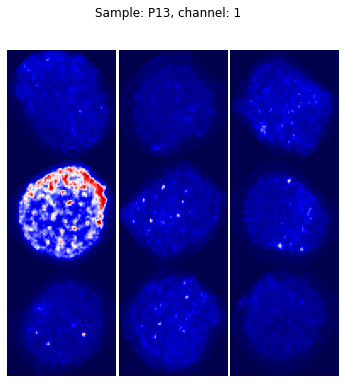

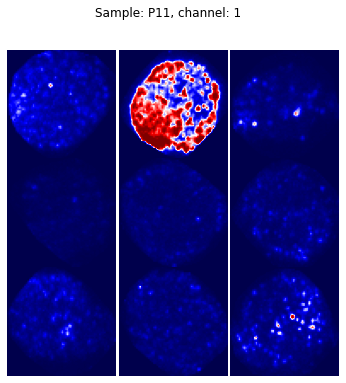

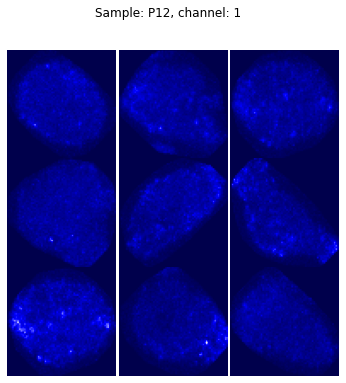

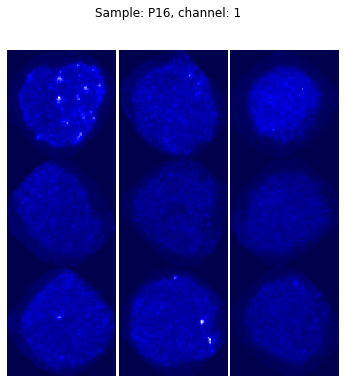

<IPython.core.display.Javascript object>

In [16]:
for k, v in pt_sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=1, cmap="seismic")

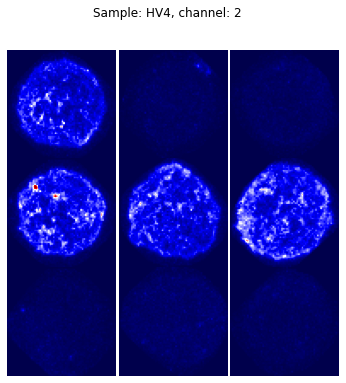

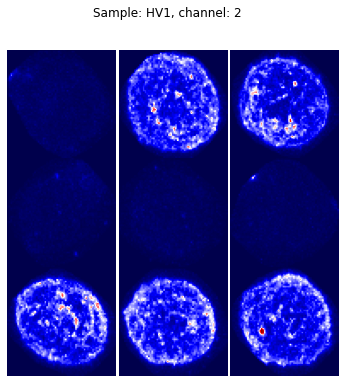

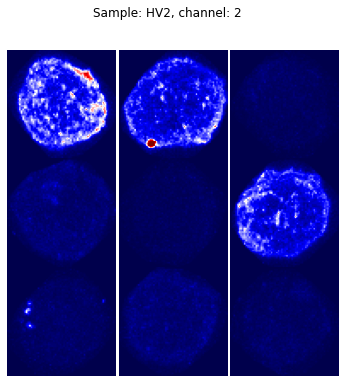

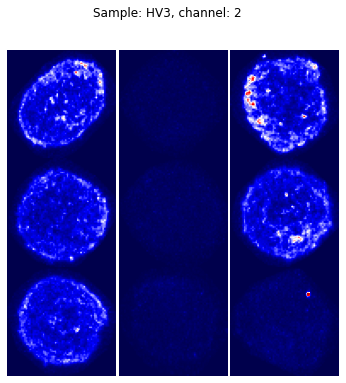

<IPython.core.display.Javascript object>

In [17]:
for k, v in hv_sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=2, cmap="seismic")

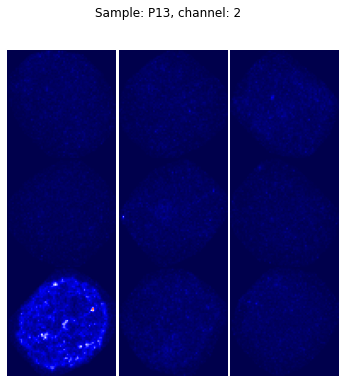

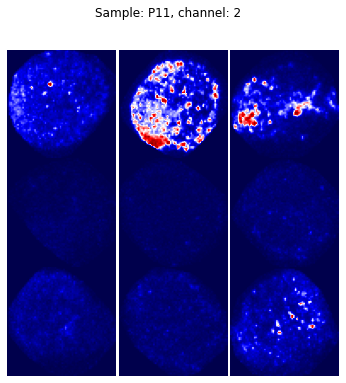

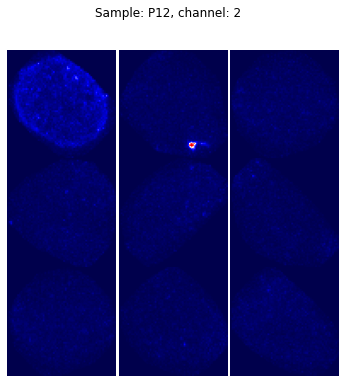

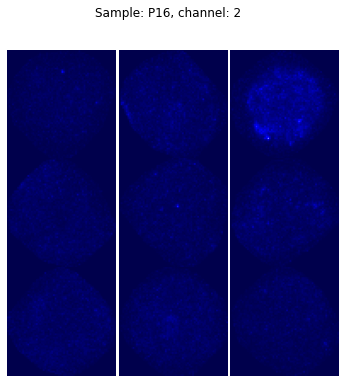

<IPython.core.display.Javascript object>

In [18]:
for k, v in pt_sample_images.items():
    plot_multi_channel_image_grid(k, v, channel=2, cmap="seismic")

The plotted nuclei illustrate the great inter- and intra-sample variability of the chromatin organization and the protein levels in human PBMCs even in healthy patients. In the following we will have a closer look at this heterogneity.

---

## 3. Preprocessing

From now on we will focus on the extracted feature sets for our analyses. To this end, we will first run a basic preprocessing pipeline that
1. Removes nuclei that did not pass the quality checks as flagged by the qc_pass attribute in the data
2. Remove any constant features and nuclei with missing values
3. Remove features correlated with a Pearson correlation of larger than 0.8
4. Normalize the data to unit variance and zero-mean.

In [19]:
filtered_data = nuclear_features.loc[nuclear_features["qc_pass"] == True]
print(
    "Nuclei that did not pass the quality check: {}/{}. Remaining: {}.".format(
        len(nuclear_features) - len(filtered_data),
        len(nuclear_features),
        len(filtered_data),
    )
)

Nuclei that did not pass the quality check: 105/2533. Remaining: 2428.


<IPython.core.display.Javascript object>

In [20]:
data = filtered_data.loc[:, (filtered_data != filtered_data.iloc[0]).any()]
data = data.loc[:, ~data.columns.str.startswith("normalized")]
data = data.dropna(axis=1)
print(
    "Removed {} constant or features with missing values. Remaining: {}.".format(
        len(filtered_data.columns) - len(data.columns), len(data.columns)
    )
)

Removed 20 constant or features with missing values. Remaining: 260.


<IPython.core.display.Javascript object>

In [21]:
n_nuclei = len(data)
data = data.dropna()
print(
    "Removed {}/{} nuclei with missing values. Remaining: {}".format(
        n_nuclei - len(data), n_nuclei, len(data)
    )
)

Removed 0/2428 nuclei with missing values. Remaining: 2428


<IPython.core.display.Javascript object>

In [22]:
# Deselect label and sample column and remove some other unimportant features
numeric_data = data.drop(
    [
        "centroid-0",
        "centroid-1",
        "orientation",
        "weighted_centroid-0",
        "weighted_centroid-1",
        "label",
        "condition",
        "sample",
    ],
    axis=1,
)
numeric_data = numeric_data.loc[:, ~numeric_data.columns.str.contains("cd4")]
numeric_data = numeric_data.loc[:, ~numeric_data.columns.str.contains("cd8")]

<IPython.core.display.Javascript object>

In [23]:
# Maintain features that have at most a Pearson correlation of 0.8
threshold = 0.8

# Control data
data_corr = numeric_data.corr().abs()
upper = data_corr.where(np.triu(np.ones(data_corr.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print(
    "Removed {}/{} features with a Pearson correlation above {}. Remaining: {}".format(
        len(to_drop),
        len(numeric_data.columns),
        threshold,
        len(numeric_data.columns) - len(to_drop),
    )
)
numeric_data = numeric_data.drop(to_drop, axis=1)

Removed 161/214 features with a Pearson correlation above 0.8. Remaining: 53


<IPython.core.display.Javascript object>

In [24]:
num_data_sc = pd.DataFrame(
    StandardScaler().fit_transform(numeric_data),
    index=numeric_data.index,
    columns=numeric_data.columns,
)
num_data_sc.describe()

min_calliper  max_calliper  smallest_largest_calliper    min_radius  \
count  2.428000e+03  2.428000e+03               2.428000e+03  2.428000e+03   
mean   6.321138e-16  7.023487e-16               5.618789e-16 -1.872930e-16   
std    1.000206e+00  1.000206e+00               1.000206e+00  1.000206e+00   
min   -5.341335e+00 -3.668186e+00              -4.921218e+00 -4.679929e+00   
25%   -6.090419e-01 -6.674284e-01              -5.454138e-01 -4.298712e-01   
50%    9.203846e-02 -2.387488e-01               1.640515e-01  1.672804e-01   
75%    6.178488e-01  5.114405e-01               7.300359e-01  6.778655e-01   
max    3.071630e+00  5.548426e+00               1.948423e+00  2.122478e+00   

         med_radius   area_bbarea  avg_curvature  std_curvature  \
count  2.428000e+03  2.428000e+03   2.428000e+03   2.428000e+03   
mean   3.652213e-15  3.979976e-16   6.555254e-16  -4.682324e-16   
std    1.000206e+00  1.000206e+00   1.000206e+00   1.000206e+00   
min   -6.773235e+00 -7.336342e+00  -6.095976e+00  -2.340580e+00   
25%   -7.202869e-01 -4.659158e-01  -6.428825e-01  -7.863557e-01   
50%   -8.917301e-02  1.425268e-01   1.250728e-01  -1.119279e-02   
75%    6.644853e-01  6.765407e-01   6.713543e-01   6.866351e-01   
max    3.484875e+00  2.357237e+00   6.004163e+00   6.394010e+00   

       npolarity_changes  max_posi_curv  ...  moments_central-1-0  \
count       2.428000e+03   2.428000e+03  ...          2428.000000   
mean        4.682324e-17   1.872930e-16  ...             0.000000   
std         1.000206e+00   1.000206e+00  ...             1.000206   
min        -2.219280e+00  -1.453845e+00  ...            -4.700467   
25%        -6.103691e-01  -5.314988e-01  ...            -0.705307   
50%        -1.022920e-01  -2.988221e-01  ...            -0.006561   
75%         4.057850e-01   1.913089e-01  ...             0.693637   
max         1.192220e+01   9.765096e+00  ...             5.356541   

       moments_hu-4  moments_hu-6  equivalent_diameter.1        extent  \
count  2.428000e+03  2.428000e+03           2.428000e+03  2.428000e+03   
mean   8.779358e-18 -2.926453e-18          -1.170581e-17 -7.023487e-16   
std    1.000206e+00  1.000206e+00           1.000206e+00  1.000206e+00   
min   -8.389873e+00 -2.259896e+01          -1.365205e+01 -4.484157e+00   
25%   -3.797140e-02  4.433163e-02          -5.819915e-01 -6.418511e-01   
50%   -3.788749e-02  4.440512e-02          -2.005026e-01  1.462565e-01   
75%   -3.785896e-02  4.446491e-02           4.930508e-01  7.450709e-01   
max    3.405652e+01  1.592851e+01           5.133148e+00  2.988588e+00   

       rel_hc_volume         rdp_1  min_dna_3d_int  q75_dna_3d_int  \
count   2.428000e+03  2.428000e+03    2.428000e+03    2.428000e+03   
mean    7.491719e-16  1.243742e-16   -9.364649e-17   -2.107046e-16   
std     1.000206e+00  1.000206e+00    1.000206e+00    1.000206e+00   
min    -6.468208e+00 -9.020132e-01   -2.395119e+00   -3.292167e+00   
25%    -6.725790e-01 -7.558381e-01   -7.278491e-01   -6.838117e-01   
50%     2.838702e-02 -3.301408e-01   -3.817396e-02    2.811584e-02   
75%     7.072463e-01  4.306327e-01    6.708258e-01    5.988853e-01   
max     4.040173e+00  9.215202e+00    4.436352e+00    5.195728e+00   

       kurtosis_dna_3d_int  
count         2.428000e+03  
mean          1.872930e-16  
std           1.000206e+00  
min          -2.121710e+00  
25%          -6.609868e-01  
50%          -1.824544e-01  
75%           4.723653e-01  
max           1.865661e+01  

[8 rows x 53 columns]

<IPython.core.display.Javascript object>

---

## 4. Overview of the nuclear space.

The tSNE plot below further emphasizes the heterogeneity in the nuclear population. Interestingly, however we can see some indication for a preferential grouping of the nuclei of the healthy volunteer 1,9 and 10 in contrast to the remaining samples.

In [25]:
tsne = TSNE(random_state=seed)
tsne_embs = tsne.fit_transform(num_data_sc)
tsne_embs = pd.DataFrame(
    tsne_embs, columns=["tsne_0", "tsne_1"], index=num_data_sc.index
)
tsne_embs.loc[:, "sample"] = np.array(data.loc[tsne_embs.index, "sample"])
tsne_embs.loc[:, "condition"] = np.array(data.loc[tsne_embs.index, "condition"])
tsne_embs.loc[:, "cd4"] = np.array(data.loc[tsne_embs.index, "cd4"])
tsne_embs.loc[:, "cd8"] = np.array(data.loc[tsne_embs.index, "cd8"])

<IPython.core.display.Javascript object>

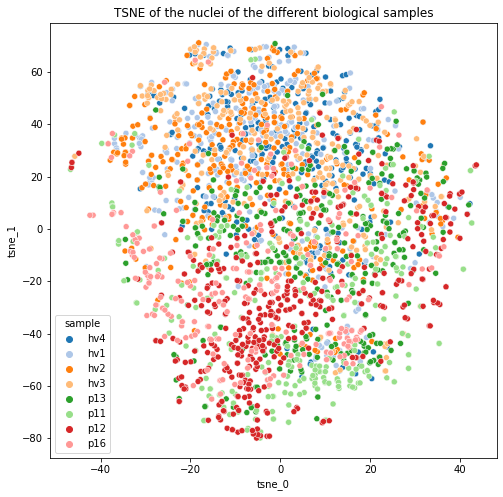

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plt.subplots(figsize=[8, 8])
sns.scatterplot(
    data=tsne_embs, x="tsne_0", y="tsne_1", hue="sample", ax=ax, palette="tab20"
)
plt.title("TSNE of the nuclei of the different biological samples")
plt.show()

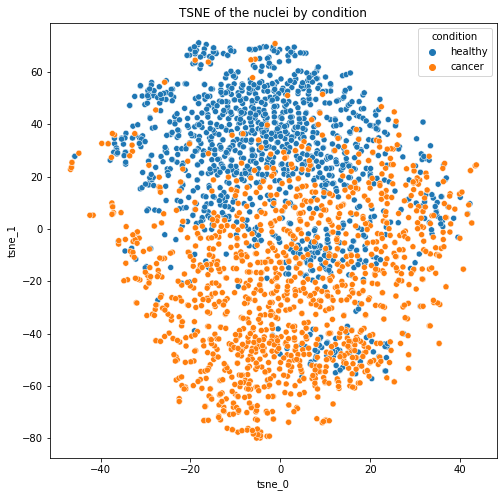

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots(figsize=[8, 8])
sns.scatterplot(data=tsne_embs, x="tsne_0", y="tsne_1", hue="condition", ax=ax)
plt.title("TSNE of the nuclei by condition")
plt.show()

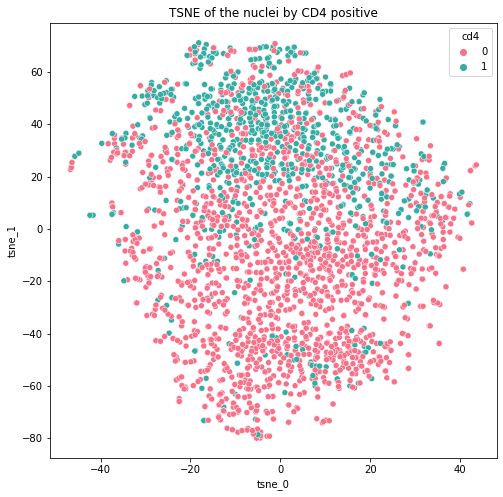

<IPython.core.display.Javascript object>

In [28]:
fig, ax = plt.subplots(figsize=[8, 8])
sns.scatterplot(
    data=tsne_embs, x="tsne_0", y="tsne_1", hue="cd4", ax=ax, palette="husl"
)
plt.title("TSNE of the nuclei by CD4 positive")
plt.show()

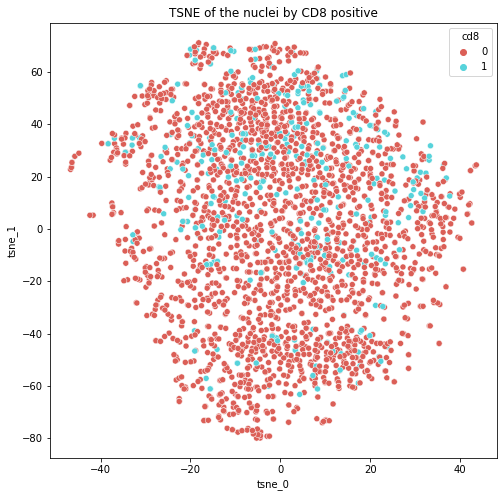

<IPython.core.display.Javascript object>

In [29]:
fig, ax = plt.subplots(figsize=[8, 8])
sns.scatterplot(data=tsne_embs, x="tsne_0", y="tsne_1", hue="cd8", ax=ax, palette="hls")
plt.title("TSNE of the nuclei by CD8 positive")
plt.show()

We see a relative clear separation of the cancer and healthy PBMCs in the tSNE space.

---

## 5. Relative cell type abundances

 Additionally, we see that the population of CD4+ T cells is enriched in the healthy samples. We will compare the relative abundances of the CD4 positive, CD8 positive, double positive and double negative in each sample. To get a better understanding of the change of the abundances of the respective cell types in the disease condition.

In [30]:
data.loc[:, "marker_label"] = np.NAN
data.loc[(data["cd4"] == 1) & (data["cd8"] == 1), "marker_label"] = "++"
data.loc[(data["cd4"] == 1) & (data["cd8"] == 0), "marker_label"] = "cd4+"
data.loc[(data["cd4"] == 0) & (data["cd8"] == 1), "marker_label"] = "cd8+"
data.loc[(data["cd4"] == 0) & (data["cd8"] == 0), "marker_label"] = "--"

<IPython.core.display.Javascript object>

In [31]:
data.head()

label  min_calliper  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0      1          56.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1      2          57.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2      3          70.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3      4          60.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_6      7          54.0   

                                                 max_calliper  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0          69.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1          69.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2          80.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3          77.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_6          67.0   

                                                 smallest_largest_calliper  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0                   0.811594   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1                   0.826087   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2                   0.875000   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3                   0.779221   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_6                   0.805970   

                                                 min_radius  max_radius  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0   25.414238   34.808384   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1   21.888176   34.632301   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2   27.110249   40.680998   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3   23.044278   40.132092   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_6   20.559301   34.613656   

                                                 med_radius  avg_radius  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0   30.449537   30.342112   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1   31.093053   30.915548   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2   36.292256   36.137461   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3   32.721444   32.905978   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_6   29.841219   29.266809   

                                                 mode_radius  d25_radius  ...  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0    25.414238   28.999196  ...   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1    21.888176   29.417745  ...   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2    27.110249   34.866873  ...   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3    23.044278   30.342576  ...   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_6    20.559301   27.658849  ...   

                                                 std_cd4_3d_int  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0     3723.045522   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1     4208.063454   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2     1153.419338   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3      914.371032   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_6      649.311363   

                                                 q75_cd4_3d_int  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0           168.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1           150.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2            87.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3            62.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_6            63.0   

                                                 median_cd4_3d_int  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0             1281.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_1             1888.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_2              105.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_3               41.0   
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_6               46.0   

                                                 kurtosis_cd4_3d_int  \
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_1_0            32.384395

<IPython.core.display.Javascript object>

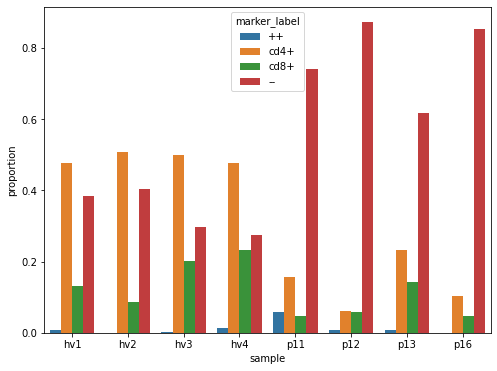

<IPython.core.display.Javascript object>

In [32]:
fig, ax = plt.subplots(figsize=[8, 6])
x, y, hue = "sample", "proportion", "marker_label"
hue_order = ["++", "cd4+", "cd8+", "--"]

l = (
    data[x]
    .sort_values(ascending=True)
    .groupby(data[hue])
    .value_counts()
    .rename(y)
    .reset_index()
)
for sample in np.unique(l["sample"]):
    l.loc[l["sample"] == sample, "proportion"] /= np.sum(
        l.loc[l["sample"] == sample, "proportion"]
    )
l.pipe(
    (sns.barplot, "data"),
    x=x,
    y=y,
    hue=hue,
    order=["hv1", "hv2", "hv3", "hv4", "p11", "p12", "p13", "p16"],
    hue_order=hue_order,
    ax=ax,
)
plt.show()

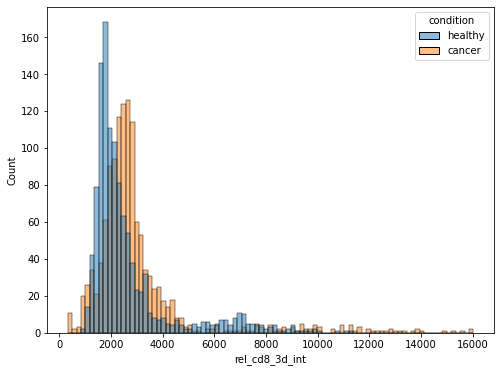

<IPython.core.display.Javascript object>

In [52]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.histplot(data=data, x="rel_cd8_3d_int", hue="condition", ax=ax)
plt.show()

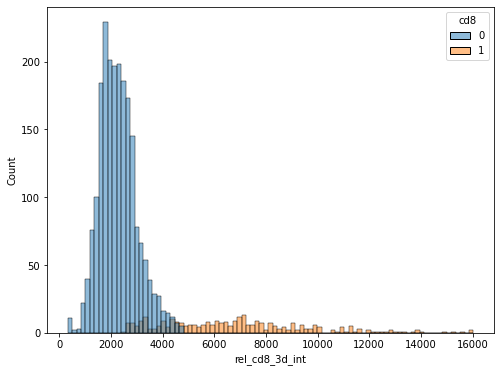

<IPython.core.display.Javascript object>

In [54]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.histplot(data=data, x="rel_cd8_3d_int", hue="cd8", ax=ax)
plt.show()

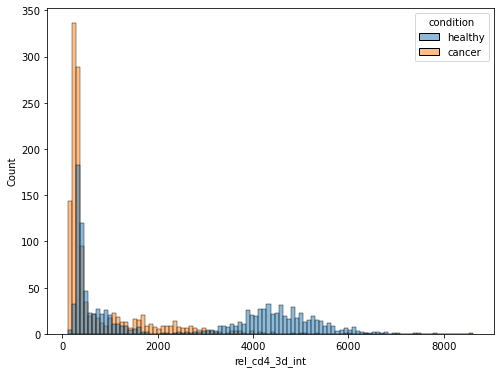

<IPython.core.display.Javascript object>

In [53]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.histplot(data=data, x="rel_cd4_3d_int", hue="condition", bins=100)
plt.show()

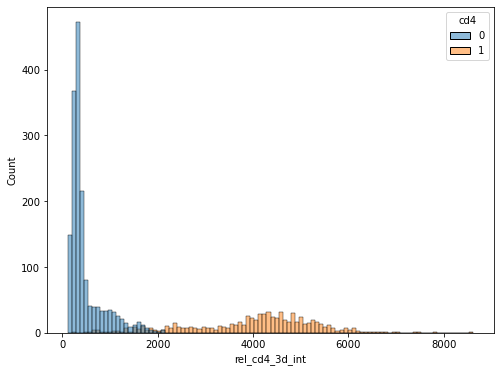

<IPython.core.display.Javascript object>

In [55]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.histplot(data=data, x="rel_cd4_3d_int", hue="cd4", bins=100)
plt.show()

In [33]:
rel_freqs = {"sample": [], "condition": [], "++": [], "cd4+": [], "cd8+": [], "--": []}
for sample in np.unique(data["sample"]):
    tmp = data.loc[data["sample"] == sample, :]
    n = len(tmp)
    rel_freqs["sample"].append(sample)
    rel_freqs["condition"].append(tmp.loc[:, "condition"][0])
    rel_freqs["++"].append(np.sum(tmp["marker_label"] == "++") / n)
    rel_freqs["cd4+"].append(np.sum(tmp["marker_label"] == "cd4+") / n)
    rel_freqs["cd8+"].append(np.sum(tmp["marker_label"] == "cd8+") / n)
    rel_freqs["--"].append(np.sum(tmp["marker_label"] == "--") / n)
rel_freqs = pd.DataFrame.from_dict(rel_freqs)

<IPython.core.display.Javascript object>

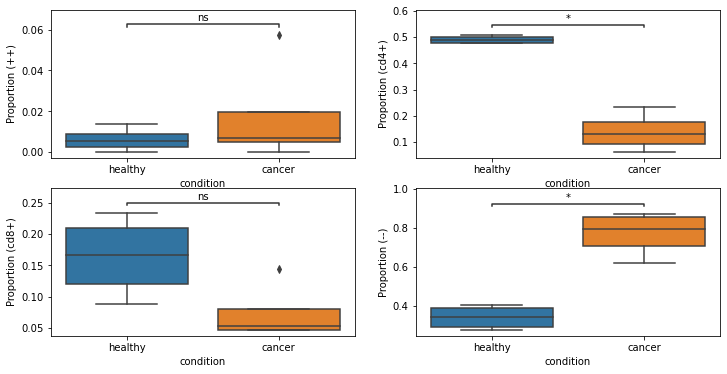

<IPython.core.display.Javascript object>

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[12, 6])
ax = ax.flatten()
ax[0] = sns.boxplot(data=rel_freqs, x="condition", y="++", ax=ax[0])
add_stat_annotation(
    ax[0],
    data=rel_freqs,
    x="condition",
    y="++",
    box_pairs=[("healthy", "cancer")],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
ax[0].set_ylabel("Proportion (++)")

ax[1] = sns.boxplot(data=rel_freqs, x="condition", y="cd4+", ax=ax[1])
add_stat_annotation(
    ax[1],
    data=rel_freqs,
    x="condition",
    y="cd4+",
    box_pairs=[("healthy", "cancer")],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
ax[1].set_ylabel("Proportion (cd4+)")

ax[2] = sns.boxplot(data=rel_freqs, x="condition", y="cd8+", ax=ax[2])
add_stat_annotation(
    ax[2],
    data=rel_freqs,
    x="condition",
    y="cd8+",
    box_pairs=[("healthy", "cancer")],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
ax[2].set_ylabel("Proportion (cd8+)")

ax[3] = sns.boxplot(data=rel_freqs, x="condition", y="--", ax=ax[3])
add_stat_annotation(
    ax[3],
    data=rel_freqs,
    x="condition",
    y="--",
    box_pairs=[("healthy", "cancer")],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
ax[3].set_ylabel("Proportion (--)")

plt.show()

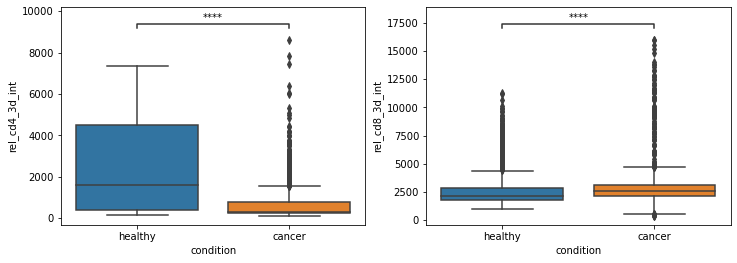

<IPython.core.display.Javascript object>

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[12, 4])
ax = ax.flatten()
ax[0] = sns.boxplot(data=data, x="condition", y="rel_cd4_3d_int", ax=ax[0])
add_stat_annotation(
    ax[0],
    data=data,
    x="condition",
    y="rel_cd4_3d_int",
    box_pairs=[("healthy", "cancer")],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
ax[1] = sns.boxplot(data=data, x="condition", y="rel_cd8_3d_int", ax=ax[1])
add_stat_annotation(
    ax[1],
    data=data,
    x="condition",
    y="rel_cd8_3d_int",
    box_pairs=[("healthy", "cancer")],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
)
plt.show()

In [62]:
from collections import Counter

np.mean(list(Counter(data.loc[:, "sample"]).values())[-4:])

318.0

<IPython.core.display.Javascript object>